## 0. Import Packages

In [ ]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from urllib.request import urlretrieve
pd.set_option('display.max_columns', 100)

## 1. Import Data File

Our Top 100 data is imported from this website:
https://data.world/kcmillersean/billboard-hot-100-1958-2017

Our emotion data is imported from this website:
https://data.world/tazwar2700/billboard-hot-100-with-lyrics-and-emotion-mined-scores

This data is cleaned according to this blog post:
https://medium.com/codex/emotion-mining-lyrics-of-all-billboard-hot-100-songs-1958-2020-3007d6963115


In [2]:
top_100_df = pd.read_csv('https://query.data.world/s/tyydeinou5t7cazcsv6svzold2z5j4')
print(top_100_df.shape)

(327895, 10)


In [3]:
emo_df = pd.read_excel('https://query.data.world/s/hic74stf4mkkgqjz3fj6fvka5swcfx')
print(emo_df.shape)

(22600, 49)


Top 100 data has 327,895 records. This makes sense as the data spans from mid 1958 to mid 2021 (64 weeks). 64 x 52 x 100 = 332,800. 

Emotion data has 22,600 data. This includes unique song titles, lyrics, and emotion.

## 2. Initial Data Observations

#### Question: What are the columns and types of data? 

In [4]:
print(top_100_df.dtypes)
print(emo_df.dtypes)

url                        object
WeekID                     object
Week Position               int64
Song                       object
Performer                  object
SongID                     object
Instance                    int64
Previous Week Position    float64
Peak Position               int64
Weeks on Chart              int64
dtype: object
Unnamed: 0                   int64
url                         object
WeekID                      object
Week Position                int64
Song                        object
Performer                   object
SongID                      object
Instance                   float64
Previous Week Position     float64
Peak Position              float64
Weeks on Chart             float64
Lyrics                      object
Artist                      object
words                       object
wordCount                    int64
languages                   object
all_words                   object
allWordCount                 int64
year            

In [5]:
print(top_100_df.head())
print(emo_df.head())

                                                 url     WeekID  \
0  http://www.billboard.com/charts/hot-100/1965-0...  7/17/1965   
1  http://www.billboard.com/charts/hot-100/1965-0...  7/24/1965   
2  http://www.billboard.com/charts/hot-100/1965-0...  7/31/1965   
3  http://www.billboard.com/charts/hot-100/1965-0...   8/7/1965   
4  http://www.billboard.com/charts/hot-100/1965-0...  8/14/1965   

   Week Position                    Song   Performer  \
0             34  Don't Just Stand There  Patty Duke   
1             22  Don't Just Stand There  Patty Duke   
2             14  Don't Just Stand There  Patty Duke   
3             10  Don't Just Stand There  Patty Duke   
4              8  Don't Just Stand There  Patty Duke   

                             SongID  Instance  Previous Week Position  \
0  Don't Just Stand TherePatty Duke         1                    45.0   
1  Don't Just Stand TherePatty Duke         1                    34.0   
2  Don't Just Stand TherePatty Duke      

#### Question: How many unique songs are in each dataset?

In [6]:
print(top_100_df['SongID'].nunique())
print(emo_df['SongID'].nunique())
print("There are " + str(top_100_df['SongID'].nunique() - emo_df['SongID'].nunique()) + " song without emotion score.")

29389
22600
There are 6789 song without emotion score.


## 3. Join Emotion_DF onto Full_DF

Remove duplicate columns from emotion data, prior to merge.

In [7]:
emo_df1 = emo_df.drop(columns = {'url', 'WeekID', 'Week Position', 'Song', 'Performer', 'Instance', 'Previous Week Position', 'Peak Position', 'Weeks on Chart'}, inplace = True)

Merge data on "SongID" column.

In [8]:
df_emo_full = pd.merge(top_100_df, emo_df, on = ['SongID'], how = 'outer', indicator = True)

#### Question: How many records are merged from each dataset?

In [9]:
df_emo_full['_merge'].value_counts()

both          269355
left_only      58540
right_only         0
Name: _merge, dtype: int64

#### Answer: There are 58,540 total records that do not have emotion information.
Why is this? Is there a time period that affects most of these?

Create a variable "YearID"

In [10]:
df_emo_full['YearID'] = df_emo_full['WeekID'].str[-4:]

Remove "Unnamed: 0" column

In [11]:
df_emo_full.drop(columns = {'Unnamed: 0'}, inplace = True)

## 4. Explore the df_emo_full dataframe

#### Question: How many missing values are associated with each column?

In [12]:
df_emo_full.info()

missing = pd.concat([df_emo_full.isnull().sum(), 100 * df_emo_full.isnull().mean()], axis=1)
missing.columns=["count", "%"]
missing.sort_values(by="count", ascending = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327895 entries, 0 to 327894
Data columns (total 50 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   url                      327895 non-null  object  
 1   WeekID                   327895 non-null  object  
 2   Week Position            327895 non-null  int64   
 3   Song                     327895 non-null  object  
 4   Performer                327895 non-null  object  
 5   SongID                   327895 non-null  object  
 6   Instance                 327895 non-null  int64   
 7   Previous Week Position   295941 non-null  float64 
 8   Peak Position            327895 non-null  int64   
 9   Weeks on Chart           327895 non-null  int64   
 10  Lyrics                   269355 non-null  object  
 11  Artist                   269355 non-null  object  
 12  words                    269355 non-null  object  
 13  wordCount                269355 non-null  fl

,count,%
emo_words,58540,17.853276
fear_normalized,58540,17.853276
sentimentScore,58540,17.853276
sentimentScore_pos,58540,17.853276
sentimentScore_neg,58540,17.853276
surprise,58540,17.853276
emoWordCount,58540,17.853276
joy,58540,17.853276
joy_normalized,58540,17.853276
sadness,58540,17.853276


#### Answer: It appears that all data from the "Top 100 data" are populated, aside from "Previous Week Position," we will look into this column further. The "Emotion data" appears to have the same count of missing records in each column, we need to look into this. 

#### Question: Does each week have all 100 records? 

In [13]:
df_emo_full['WeekID'].value_counts()

7/17/1965     100
8/29/2009     100
6/6/2009      100
6/13/2009     100
6/20/2009     100
             ... 
11/30/1991     99
12/7/1991      99
12/14/1991     99
11/23/1991     99
11/16/1991     99
Name: WeekID, Length: 3279, dtype: int64

In [14]:
week_check = df_emo_full[df_emo_full['WeekID'].isin(['11/16/1991', '11/23/1991', '11/30/1991', '12/7/1991', '12/14/1991'])]
week_check['Week Position'].value_counts();
#Remove ";" to see output

#### Answer: All except for 5 weeks have the expected 100 placements. The 5 cases with only 99 placements are in consecutive weeks from November to December of 1991. 
The missing placements in those weeks were either 99, 98, 95, or 92.

#### Question: We noticed a significant amount of missing "emotion data." Is there a time period where emotion data is missing the most? 

1959    2039
1961    1829
1962    1769
1960    1736
1963    1684
        ... 
2004     434
2011     429
2010     425
2012     369
2009     353
Name: YearID, Length: 64, dtype: int64


/Users/harrisonchaseweber/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


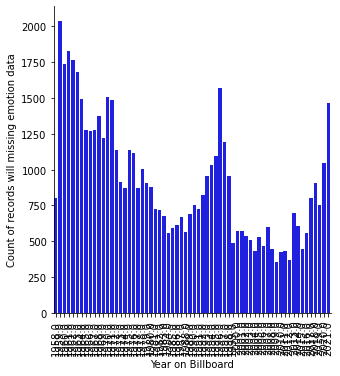

In [15]:
miss_emo_check = df_emo_full[df_emo_full['_merge'] == 'left_only']
print(miss_emo_check['YearID'].value_counts())
#Remove ";" to see output
miss_emo_check['YearID_num'] = miss_emo_check['YearID'].astype(float)
sns.catplot(data = miss_emo_check, x = 'YearID_num', kind = "count", color = "b")
plt.xlabel("Year on Billboard")
plt.ylabel("Count of records will missing emotion data")
plt.xticks(rotation = 90)
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

#### Answer: It appears that historical records and most recent data are missing emotional data more often (there is also a rise of missing values in the 90s). How do we want to handle these? Remove completely? Supplement with the average/mean? Fill with zero? 

#### Question: What are the quantiles of our numeric data?

In [16]:
df_emo_full.describe()

,Week Position,Instance,Previous Week Position,Peak Position,Weeks on Chart,wordCount,allWordCount,year,MTLD,TTR,CTTR,sentimentScore,sentimentScore_pos,sentimentScore_neg,emoWordCount,joy,joy_normalized,sadness,sadness_normalized,anger,anger_normalized,disgust,disgust_normalized,trust,trust_normalized,anticipation,anticipation_normalized,fear,fear_normalized,surprise,surprise_normalized,emo_score,happy,happy_normalized,sorrow,sorrow_normalized
count,327895.000000,327895.000000,295941.000000,327895.000000,327895.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000,269355.000000
mean,50.499309,1.072538,47.604066,41.358307,9.153793,74.242334,175.871786,1990.483941,35.873440,0.342439,4.231602,0.487275,0.168049,0.083886,80.446960,10.204082,0.066302,3.959016,0.025495,2.832443,0.014512,2.086039,0.011103,7.965993,0.048885,4.170399,0.026035,3.238855,0.018841,1.860083,0.011209,36.316909,20.030158,0.126397,16.286752,0.095986
std,28.865707,0.334188,28.056915,29.542497,7.590281,45.281149,104.450682,17.646991,18.624751,0.101897,1.183552,0.782028,0.098949,0.072694,53.392857,8.448962,0.050177,4.188860,0.026725,4.435792,0.018083,3.363149,0.015069,7.197093,0.039670,4.107091,0.023252,4.106952,0.021406,2.722920,0.014281,24.898036,15.448386,0.087179,15.045816,0.069288
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1958.000000,1.000000,0.009238,0.135926,-0.999900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.500000,1.000000,23.000000,14.000000,4.000000,47.000000,105.000000,1976.000000,22.423604,0.271021,3.444401,0.011600,0.096000,0.032000,44.000000,4.655000,0.029801,1.219000,0.008015,0.438000,0.003202,0.250000,0.001812,3.088000,0.022323,1.569000,0.010630,0.719000,0.005208,0.461000,0.003127,19.441000,9.737000,0.066667,6.833000,0.050038
50%,50.000000,1.000000,47.000000,39.000000,7.000000,62.000000,146.000000,1991.000000,32.048999,0.331126,4.071432,0.969600,0.150000,0.065000,67.000000,8.075000,0.053653,2.780000,0.017735,1.339000,0.009259,0.984000,0.006494,6.003000,0.038497,3.096000,0.019890,1.935000,0.012700,1.142000,0.007357,30.059000,16.234000,0.104494,11.960000,0.080333
75%,75.000000,1.000000,72.000000,66.000000,13.000000,84.000000,213.000000,2006.000000,45.515644,0.402117,4.832972,0.994600,0.222000,0.116000,103.000000,13.097000,0.089331,5.270000,0.034127,3.360000,0.019558,2.460000,0.014513,10.604000,0.063727,5.432000,0.034101,4.196000,0.025041,2.350000,0.014273,46.540000,25.618000,0.161796,20.746000,0.123071
max,100.000000,10.000000,100.000000,100.000000,87.000000,395.000000,1363.000000,2020.000000,205.195789,1.000000,11.743619,1.000000,0.745000,0.726000,774.000000,139.523000,0.483700,67.410000,0.327168,85.108000,0.298526,60.481000,0.263071,100.805000,0.559818,73.396000,0.375000,61.682000,0.354896,81.191000,0.284482,416.824000,261.186000,0.930187,231.951000,1.002444


#### Question: Do some songs actually have less than 5 lyrics?

In [17]:
lyric_check = df_emo_full[df_emo_full['wordCount'] < 5]
lyric_check[['SongID', 'wordCount']].value_counts()

SongID                                          wordCount
Around The WorldDaft Punk                       3.0          20
The HustleVan McCoy And The Soul City Symphony  1.0          19
Fly, Robin, FlySilver Convention                3.0          17
Do It Any Way You WannaPeoples Choice           4.0          16
HijackHerbie Mann                               1.0          15
Walk In The NightJr. Walker & The All Stars     2.0          12
RockitHerbie Hancock                            2.0           9
The PopcornJames Brown                          3.0           9
Your LoveKeith Sweat                            4.0           9
Cleo's BackJr. Walker & The All Stars           3.0           8
Mr. SongwriterConnie Stevens                    4.0           8
Peace Brother PeaceBill Medley                  3.0           7
Lowdown PopcornJames Brown                      1.0           6
Beautiful TripKid Cudi                          4.0           1
dtype: int64

#### Question: Is Previous Week Position missing or 0 when a new song enters the chart? 

In [18]:
print(df_emo_full['Previous Week Position'].min())
print(df_emo_full['Previous Week Position'].isnull().sum())

1.0
31954


### Fill missing Previous Week Position with 999.

In [19]:
df_emo_full['Previous Week Position'] = df_emo_full['Previous Week Position'].fillna(999)

#### Answer: It appears that new songs have a "Previous Week Position" of missing. 

#### Question: What are the distributions of numberical variables visualized?

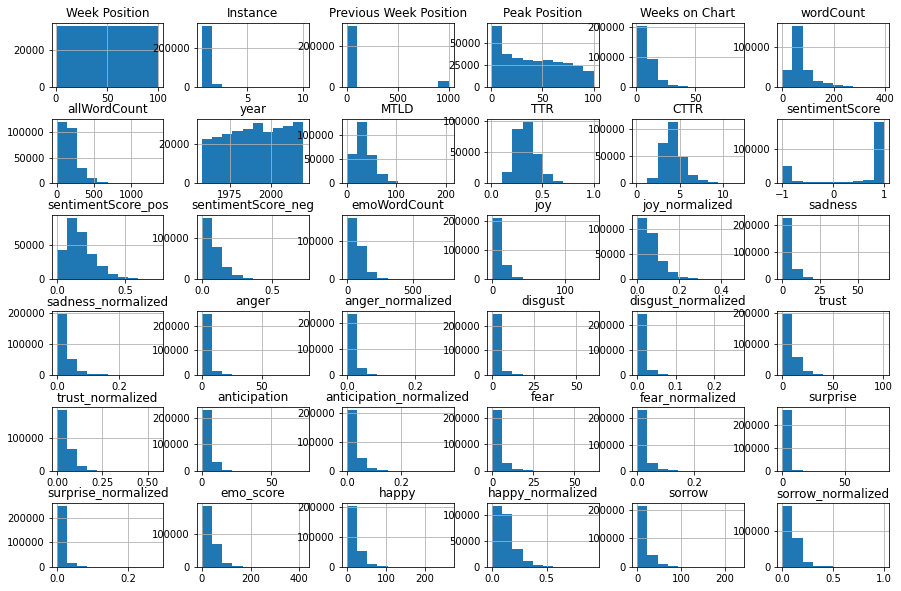

In [20]:
df_emo_full.hist(figsize = (15,10))
plt.subplots_adjust(hspace=.5);

#### Question: The emotional variables look skewed, explore this further.
Note: The "normalized" emotional variable take into account "word count" for each song. These may be more reliable measures.

In [21]:
for i in ["joy_normalized", "sadness_normalized", "anger_normalized", "disgust_normalized", "trust_normalized", "anticipation_normalized", "fear_normalized", "surprise_normalized", "happy_normalized", "sorrow_normalized", "emo_score", "emoWordCount", "sentimentScore", "sentimentScore_pos", "sentimentScore_neg"]:
    print("Summary for ", i, ":")
    print(df_emo_full[i].quantile(np.arange(0, 1.1, .1)))
    print(df_emo_full[i].mean())

Summary for  joy_normalized :
0.0    0.000000
0.1    0.016901
0.2    0.025651
0.3    0.034087
0.4    0.043521
0.5    0.053653
0.6    0.065354
0.7    0.080205
0.8    0.099929
0.9    0.132831
1.0    0.483700
Name: joy_normalized, dtype: float64
0.06630231306866584
Summary for  sadness_normalized :
0.0    0.000000
0.1    0.002892
0.2    0.006370
0.3    0.009655
0.4    0.013441
0.5    0.017735
0.6    0.022959
0.7    0.029551
0.8    0.039514
0.9    0.056691
1.0    0.327168
Name: sadness_normalized, dtype: float64
0.02549511576771733
Summary for  anger_normalized :
0.0    0.000000
0.1    0.000000
0.2    0.002033
0.3    0.004275
0.4    0.006593
0.5    0.009259
0.6    0.012575
0.7    0.016831
0.8    0.022827
0.9    0.033691
1.0    0.298526
Name: anger_normalized, dtype: float64
0.014512188968819492
Summary for  disgust_normalized :
0.0    0.000000
0.1    0.000000
0.2    0.000836
0.3    0.002795
0.4    0.004566
0.5    0.006494
0.6    0.008979
0.7    0.012329
0.8    0.017163
0.9    0.026695
1.0 

#### Question: Are the emotion scores associated with decade? 

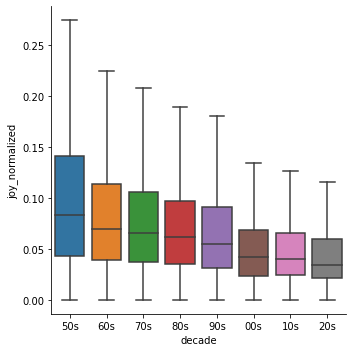

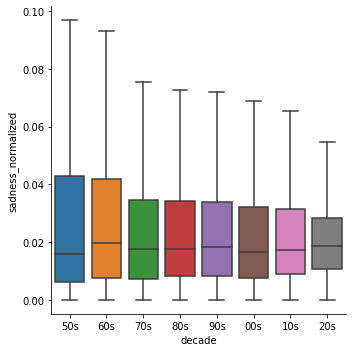

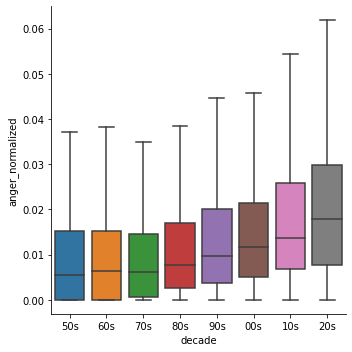

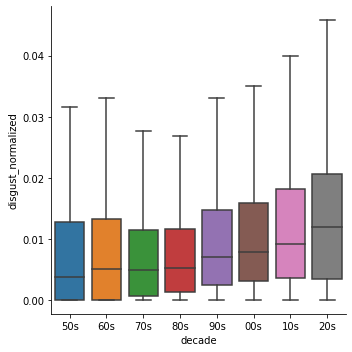

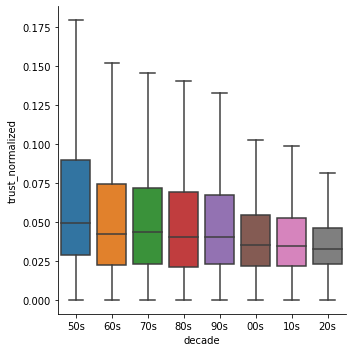

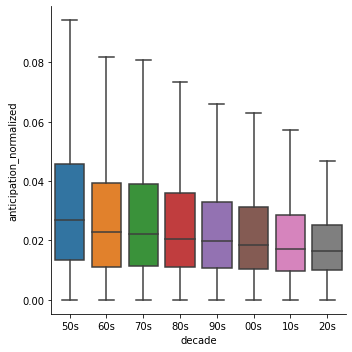

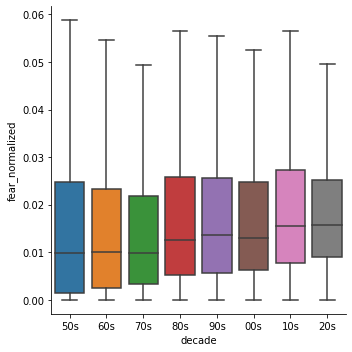

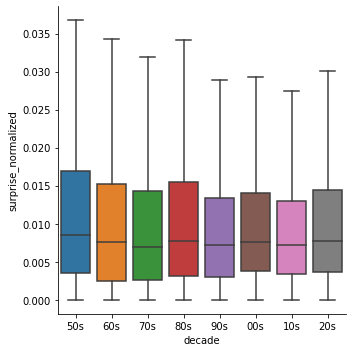

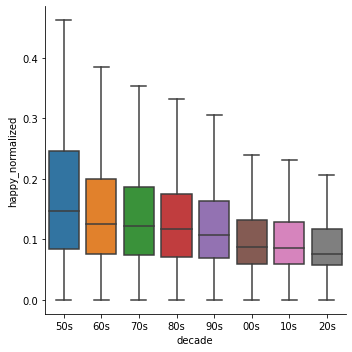

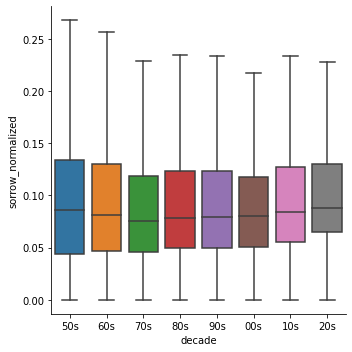

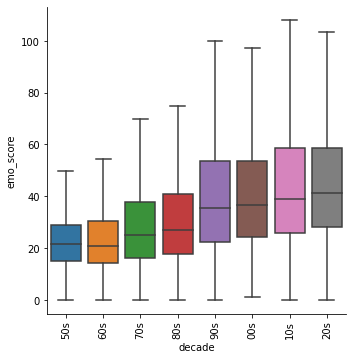

In [22]:
decade_order = ["50s", "60s", "70s", "80s", "90s", "00s", "10s", "20s"]
sns.catplot(data = df_emo_full, x = "decade", y = "joy_normalized", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "sadness_normalized", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "anger_normalized", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "disgust_normalized", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "trust_normalized", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "anticipation_normalized", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "fear_normalized", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "surprise_normalized", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "happy_normalized", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "sorrow_normalized", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "emo_score", kind = "box", order = decade_order, sym = "")
plt.xticks(rotation = 90)
plt.show()

#### Answer: There appears to be some trend between emotional scores and decade. This is not the case for each score however. The largest differences in median appear to be in Joy, Anger, and Disgust.

#### Question: What does the decade distribution of other missing variables look like? 

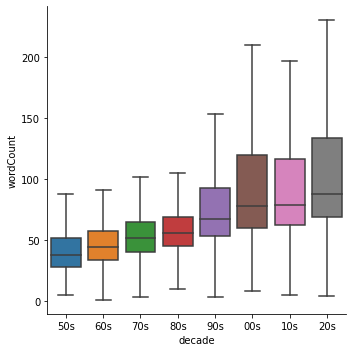

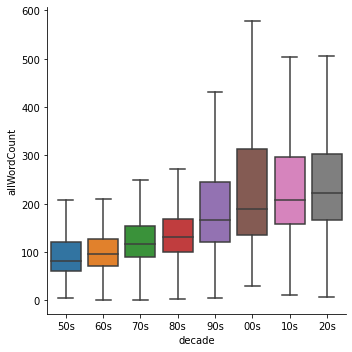

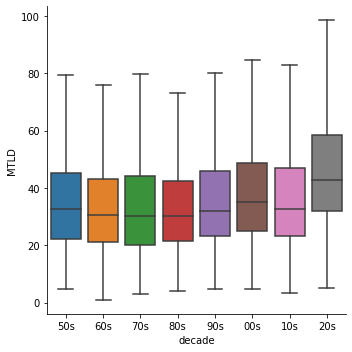

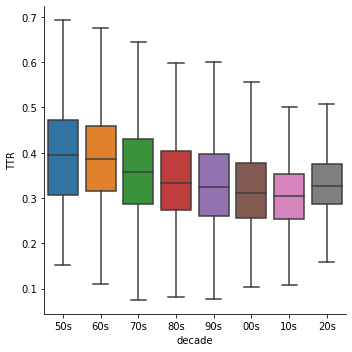

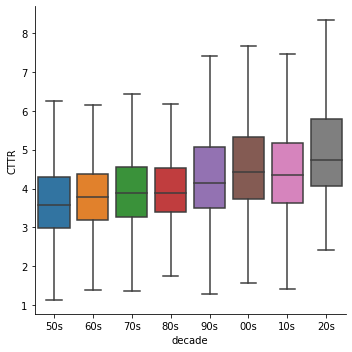

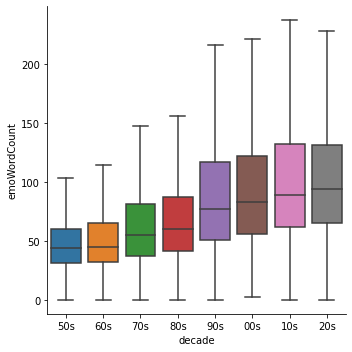

In [23]:
decade_order = ["50s", "60s", "70s", "80s", "90s", "00s", "10s", "20s"]
sns.catplot(data = df_emo_full, x = "decade", y = "wordCount", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "allWordCount", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "MTLD", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "TTR", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "CTTR", kind = "box", order = decade_order, sym = "")
sns.catplot(data = df_emo_full, x = "decade", y = "emoWordCount", kind = "box", order = decade_order, sym = "")
plt.show()

#### Answer: These variables also appear to have some relation to decade.

## 5. Fill Missing Values

Re-visit the missing values in our dataset. What are they?

In [24]:
missing = pd.concat([df_emo_full.isnull().sum(), 100 * df_emo_full.isnull().mean()], axis=1)
missing.columns=["count", "%"]
missing.sort_values(by="count", ascending = False);
#Remove ";" to see output

Almost 18% of our emotion data scores are missing. Due to the skewed distribution of these scores, we will fill missing values with the "median" value. A potential future verison may use the respective decade median for supplementation, since we see some differences in the medians for each decade.

In [25]:
for i in ["wordCount", "allWordCount", "MTLD", "TTR", "CTTR", "emoWordCount", "joy", "joy_normalized", "sadness", "sadness_normalized", "anger", "anger_normalized", "disgust", "disgust_normalized", "trust", "trust_normalized", "anticipation", "anticipation_normalized", "fear", "fear_normalized", "surprise", "surprise_normalized", "emo_score", "happy", "happy_normalized", "sorrow", "sorrow_normalized", "sentimentScore_pos", "sentimentScore_neg"]:
    df_emo_full[i].fillna(df_emo_full[i].median(), inplace = True)

In our distributions, we see that "sentimentScore" has an odd distribution. We will supplement missing values with "0" for this case.

In [26]:
df_emo_full['sentimentScore'] = df_emo_full['sentimentScore'].fillna(0)

We have missing "decade" and "year" information. These can be supplemented from our "YearID" variable we created earlier. 

In [27]:
df_emo_full["year"].dtypes

dtype('float64')

In [28]:
df_emo_full["year"] = df_emo_full["year"].fillna(df_emo_full["YearID"].astype(float))


In [29]:
df_emo_full['year_temp'] = df_emo_full["YearID"].str[-2:].astype(int)
df_emo_full.loc[df_emo_full['year_temp'].between(50, 59), 'DecadeID'] = '50s'
df_emo_full.loc[df_emo_full['year_temp'].between(60, 69), 'DecadeID'] = '60s'
df_emo_full.loc[df_emo_full['year_temp'].between(70, 79), 'DecadeID'] = '70s'
df_emo_full.loc[df_emo_full['year_temp'].between(80, 89), 'DecadeID'] = '80s'
df_emo_full.loc[df_emo_full['year_temp'] > 90, 'DecadeID'] = '90s'
df_emo_full.loc[df_emo_full['year_temp'].between(0, 9), 'DecadeID'] = '00s'
df_emo_full.loc[df_emo_full['year_temp'].between(10, 19), 'DecadeID'] = '10s'
df_emo_full.loc[df_emo_full['year_temp'].between(20, 29), 'DecadeID'] = '20s'

df_emo_full['decade'] = df_emo_full['decade'].fillna(df_emo_full['DecadeID'])

In [30]:
missing = pd.concat([df_emo_full.isnull().sum(), 100 * df_emo_full.isnull().mean()], axis=1)
missing.columns=["count", "%"]
missing.sort_values(by="count", ascending = False)
#Remove ";" to see output

,count,%
languages,58540,17.853276
Lyrics,58540,17.853276
emo_words,58540,17.853276
all_words,58540,17.853276
words,58540,17.853276
Artist,58540,17.853276
DecadeID,5200,1.585874
decade,753,0.229647
happy,0,0.000000
anger_normalized,0,0.000000


Note, some of the categorical variables, such as lyrics, words, language, and artist cannot be imputed.

## 6. Create and Analyse Responce Variable

Here we create a success indicator, songs that are in the top 10 recieve an indicator of 1, those that do not receive an indicator of 0. 

In [31]:
df_emo_full['SuccessInd'] = np.where(df_emo_full['Week Position'] <= 10, 1, 0)

In [32]:
df_emo_full['SuccessInd'].value_counts()

0    295105
1     32790
Name: SuccessInd, dtype: int64

## 7. Export Data

In [33]:
df_emo_full.shape

(327895, 53)

In [34]:
df_emo_full.to_csv('/Users/harrisonchaseweber/Desktop/Springboard/Billboard Top 10 Prediction/DataFiles/df_emo_full.csv')

## 8. Summary

In this notebook, we import data from two sources. One dataset includes all rankings (current and previous) of the top 100 songs for each week since 1957. The second dataset includes artist, lyrics, word-count, and emotional scores for each unique song. By merging these two datasets together we have a comprehensive dataset of all Billboard Top 100 songs with their associated lyric and emotional scores.

We notice that all but 5 weeks have the full top 100 songs. The 5 weeks that are missing scores are located in 5 consecutive weeks in November/December of 1991. The missing scores are either 99, 98, 95, or 92. Since there are only 
5 missing records and all are in bottom scores, we leave the data as is. 

We notice that there are some songs with less than 5 lyrics, doing som spot checking we find that these numbers appear to be accurate. For example, Around the World by Daft Punk has a lyric count of 3. As this song repeats the lyrics "Around the World" continuously, the count appears accurate. 

When we merge the emotional scores data onto the full Billboard Top 100 data, we find that 18% of our records do not receive an emotional score in the merge. Looking at the distribution of years in this case, most of the missing values come from earlier years and more recent years with a spike in the 90s as well. Because the distribution of populated emotional scores is skewed, we supplement missing values with the median. (In the future we may use the median for each respective decade as there appears to be some differences in the median per decade.)

The final step of our data wrangling, we create a variable that indicates success. In our study we are looking at songs that make it into the top 10 of the Billboard 100. A song with a "Week Position" of 10 or less is considered a success, all others are not. 